# PART 1: LOAD AND CLEAN DATA

## Resources: 
https://machinelearningmastery.com/xgboost-for-regression/  
https://xgboost.readthedocs.io/en/stable/

https://www.kaggle.com/datasets/rkiattisak/salaly-prediction-for-beginer

Question: what affects on the salary?

In [1]:
# the usual imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics

/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# install the XGBoost library
!pip install xgboost

# sudo pip install xgboost
# did not work on Macintosh

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 3.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.8/19.8 MB 6.7 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
daal4py 2021.6.0 requires daal==2021.4.0, which is not installed.
numba 0.55.1 requires numpy<1.22,>=1.18, but you have numpy 1.24.4 which is incompatible.


In [3]:
# check xgboost version
import xgboost
print(xgboost.__version__)

2.0.3


In [4]:
# import XGBRegressor from xgboost
from xgboost import XGBRegressor

In [5]:
df = pd.read_csv("Salary Data.csv")

In [6]:
df.head()

# Gender --> 1 or 0
# Education Level --> check unique values and change to numeric
# Job Title --> check unique values and try to make classification

,Age,Gender,Education Level,Job Title,Years of Experience,Salary
0,32.0,Male,Bachelor's,Software Engineer,5.0,90000.0
1,28.0,Female,Master's,Data Analyst,3.0,65000.0
2,45.0,Male,PhD,Senior Manager,15.0,150000.0
3,36.0,Female,Bachelor's,Sales Associate,7.0,60000.0
4,52.0,Male,Master's,Director,20.0,200000.0


In [7]:
df.describe()

,Age,Years of Experience,Salary
count,373.000000,373.000000,373.000000
mean,37.431635,10.030831,100577.345845
std,7.069073,6.557007,48240.013482
min,23.000000,0.000000,350.000000
25%,31.000000,4.000000,55000.000000
50%,36.000000,9.000000,95000.000000
75%,44.000000,15.000000,140000.000000
max,53.000000,25.000000,250000.000000


In [8]:
# check duplicates
df.duplicated().sum()

# I think, it does not matter becuase
# it is very possible that people with same background 
# have the same salary on the same positions

50

In [9]:
# check NaN values
df.isna().sum()

Age                    2
Gender                 2
Education Level        2
Job Title              2
Years of Experience    2
Salary                 2
dtype: int64

In [10]:
#drop NaN values
df = df.dropna()

In [11]:
# Gender --> 1 or 0
from sklearn.preprocessing import LabelEncoder
variables = ['Gender']
encoder = LabelEncoder()

# apply the LabelEncoder to specific columns in our DataFrame (see variables above)
df[variables] = df[variables].apply(encoder.fit_transform)

In [12]:
# Education Level --> check unique values and change to numeric
unique_values = df['Education Level'].unique()
unique_values

array(["Bachelor's", "Master's", 'PhD'], dtype=object)

In [13]:
# pandas get_dummies to change data to numeric
variable = 'Education Level'
dummies = pd.get_dummies(df[variable]).astype(int)
df = pd.concat([df, dummies], axis=1).drop(columns=variable)

In [14]:
# drop the last column
columns_to_drop = ["PhD"]
df = df.drop(columns=columns_to_drop)

In [15]:
# Rename the columns
# otherwise, I struggle with these different commas
df = df.rename(columns={"Bachelor's": "Bachelors", "Master's": "Masters"})

In [16]:
# Job Title --> check unique values and try to make classification
unique_values_count = df['Job Title'].nunique()
unique_values_count

174

In [17]:
# Job Title --> check unique values and try to make classification
unique_values = df['Job Title'].unique()
unique_values

array(['Software Engineer', 'Data Analyst', 'Senior Manager',
       'Sales Associate', 'Director', 'Marketing Analyst',
       'Product Manager', 'Sales Manager', 'Marketing Coordinator',
       'Senior Scientist', 'Software Developer', 'HR Manager',
       'Financial Analyst', 'Project Manager', 'Customer Service Rep',
       'Operations Manager', 'Marketing Manager', 'Senior Engineer',
       'Data Entry Clerk', 'Sales Director', 'Business Analyst',
       'VP of Operations', 'IT Support', 'Recruiter', 'Financial Manager',
       'Social Media Specialist', 'Software Manager', 'Junior Developer',
       'Senior Consultant', 'Product Designer', 'CEO', 'Accountant',
       'Data Scientist', 'Marketing Specialist', 'Technical Writer',
       'HR Generalist', 'Project Engineer', 'Customer Success Rep',
       'Sales Executive', 'UX Designer', 'Operations Director',
       'Network Engineer', 'Administrative Assistant',
       'Strategy Consultant', 'Copywriter', 'Account Manager',
      

In [18]:
# I decided to make clustering with all job titles
# in order to avoid to have a lot of columns
# and at the same time to have numeric data

# import modules
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import cosine_similarity

# apply TF-IDF vectorization to job titles to convert them into numerical vectors.
# assign cluster labels to job titles based on the clustering results.
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df['Job Title'])

# calculate cosine similarity between job titles to measure their similarity.
cosine_sim = cosine_similarity(tfidf_matrix)

# perform hierarchical clustering using AgglomerativeClustering.
cluster = AgglomerativeClustering(n_clusters=None, affinity='cosine', linkage='average', distance_threshold=0.2)
cluster.fit(cosine_sim)

# assign cluster labels to job titles
df['Job Title Cluster'] = cluster.labels_

# print the result
print(df[['Job Title', 'Job Title Cluster']])

                         Job Title  Job Title Cluster
0                Software Engineer                 27
1                     Data Analyst                 24
2                   Senior Manager                  4
3                  Sales Associate                 49
4                         Director                  9
..                             ...                ...
370       Senior Marketing Analyst                 13
371         Director of Operations                 42
372         Junior Project Manager                  5
373  Senior Operations Coordinator                 12
374        Senior Business Analyst                 18

[373 rows x 2 columns]


In [19]:
# Count the total number of clusters
total_clusters = cluster.n_clusters_

print("Total number of clusters:", total_clusters)

Total number of clusters: 91


In [20]:
# drop the Job Title column
columns_to_drop = ["Job Title"]
df = df.drop(columns=columns_to_drop)

In [21]:
# check data
df.head()

,Age,Gender,Years of Experience,Salary,Bachelors,Masters,Job Title Cluster
0,32.0,1,5.0,90000.0,1,0,27
1,28.0,0,3.0,65000.0,0,1,24
2,45.0,1,15.0,150000.0,0,0,4
3,36.0,0,7.0,60000.0,1,0,49
4,52.0,1,20.0,200000.0,0,1,9


# PART 2: Balance of data

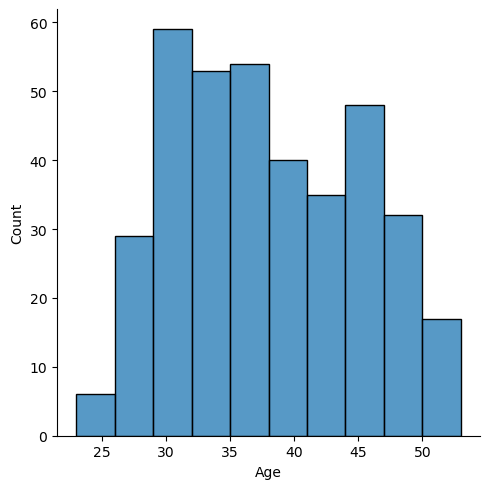

In [22]:
sns.displot(df, x="Age")

# not well balanced but we cannot delete more data 
# because we do not have much

In [23]:
class_counts = df['Gender'].value_counts()
class_counts

# well balanced

1    194
0    179
Name: Gender, dtype: int64

In [24]:
sns.displot(df, x="Salary")

# there is some outliers that 
# we will remove lates

In [25]:
# remove ouliers
from scipy import stats
df = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]

# PART 3: The train/test –split

In [26]:
df.columns

Index(['Age', 'Gender', 'Years of Experience', 'Salary', 'Bachelors',
       'Masters', 'Job Title Cluster'],
      dtype='object')

In [27]:
# if you  have more than one independent variables, list them all here
# leave out the target variable! (dependent variable)
X = df[['Age', 'Gender', 'Years of Experience','Bachelors',
       'Masters', 'Job Title Cluster']]


# here we have only the target variable (dependent variable)
y = df['Salary']

In [28]:
# create train and test sets of your dataset
# random_state is optional, you can lock this down in order to 
# to get same results always
# this examples reserves 30% for test data, 70% for training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [29]:
# create an empty XGBRegressor model
# and fit it with out data 

lm = XGBRegressor()
lm.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

# PART 5: Error and performance metrics

In [30]:
# make test predictions with new data with our model
predictions = lm.predict(X_test)

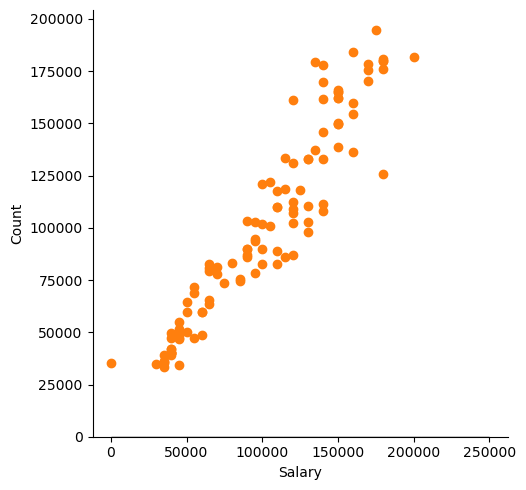

In [31]:
# these values follow a line = good predictions
# we basically compare the predicted values 
# to true test values and see the differences
plt.scatter(y_test, predictions)
plt.show()

# a very good linear regression :)
# but there are still some outliers

# PART 6: Create a tester row for metrics

In [32]:
# let's try with some new imaginary data
tester_row = {
    'Age': 25, 
    'Gender': 1, 
    'Years of Experience': 3, 
    'Bachelors': 1,
    'Masters': 1, 
    'Job Title Cluster': 24
}

# convert to pandas-format
tester_row = pd.DataFrame([tester_row])

In [33]:
# use our model to predict our tester_row data
year_salary = lm.predict(tester_row)[0]
month_salary = year_salary / 12

print()
print(f"Predicted year salary: {round(float(year_salary), 2)}")
print(f"Predicted monthly salary: {round(float(month_salary), 2)}")


Predicted year salary: 39353.23
Predicted monthly salary: 3279.44


In [34]:
# Lower values indicate better performance - MAE, MSE, RMSE
# R-squared: 1 is perfect, 0 is worst outcome

# MAE - Mean average error
# The average of all errors
# Simple, but doesn't take large errors into account that much
print("MAE")
print(round(metrics.mean_absolute_error(y_test, predictions), 2))

# MSE - Mean square error
# Errors are computed in the power of 2 (squared) => larger mistakes are emphasized
print("\nMSE")
print(round(metrics.mean_squared_error(y_test, predictions), 2), "^2")

# RMSE - Root mean square error
# the most common error metric used in regression
# 0 = perfect RMSE-score, 1 = worst possible RMSE-score
print('\nRMSE:')
print(round(np.sqrt(metrics.mean_squared_error(y_test, predictions)), 2))

# R-squared. 0 = the model describes the dataset poorly
# 1 = model describes the dataset perfectly
print('\nR-squared:')
print(round(metrics.r2_score(y_test, predictions), 2))

# MAE: quite big if we take into account that
# the max salary is 220 000

# R-squared: a very good result

MAE
10581.3

MSE
237392635.25 ^2

RMSE:
15407.55

R-squared:
0.89


/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


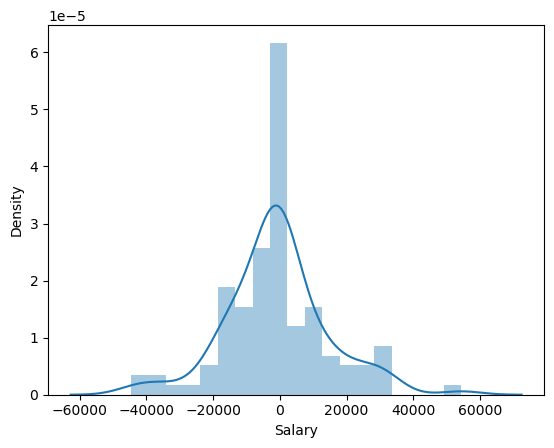

In [35]:
# if the prediction distribution are far from normal distribution
# then the model is not probably good enough
# distplot is deprecating in future pandas-version
# unfortunately, there's no exact alternative to do this plot at the moment
sns.distplot((y_test - predictions))
plt.show()
plt.close()

# we have a good distribution